# **Laboratorio 6: Aprendizaje activo**
**Estudiantes:**
Matías Héctor Pavón

Juan José Montaño Molina

Juan Manuel Rúa Echalar

**Ejercicio:**
Los datos corresponden a un dataset para el reconocimiento de caracteres japoneses manuscrito.

Características: 384

etiquetas: 10

ejemplos: 25000

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [4]:
# Cargar el nuevo conjunto de datos
data_np = pd.read_csv('/content/drive/MyDrive/IA/train_data.csv')
data_np = data_np.drop(data_np.columns[0], axis=1)
data = data_np.to_numpy()

# Extract features and labels from the dataset
X = data[:1000, 1:]  # Features
y = data[:1000, 0]   # Labels

# Tamaño del conjunto de datos
m = y.size

# Preprocess for testing (test dataset)
X_test = data[1000:25000, 1:]  # Test features
Y_test = data[1000:25000, 0]   # Test labels

# Replace label '10' with '0'
y[y == 10] = 0
Y_test[Y_test == 10] = 0

# llama featureNormalize con los datos cargados
#X, mu, sigma = featureNormalize(X)
#X_test,mu_test,sigma_test=featureNormalize(X_test)

# Create a Pandas DataFrame for training data
X_train = pd.DataFrame(X)
y_train =pd.DataFrame(y)
# Size of the dataset
m = y.size

# Number of clusters for K-Means
k = 50

In [2]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


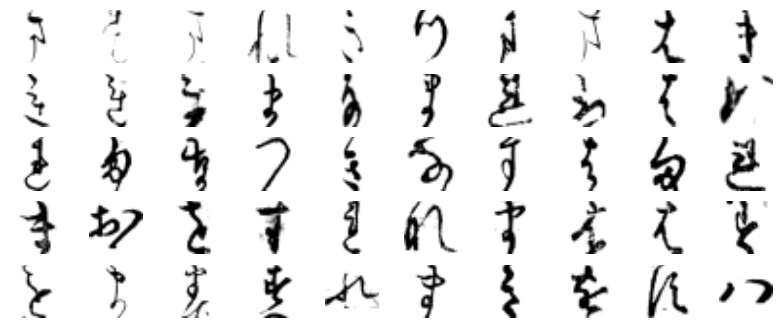

Number of samples in X_test: 24000
Number of samples in y_test: 24000
CPU times: user 5.98 s, sys: 1.88 s, total: 7.87 s
Wall time: 5.05 s


0.6130833333333333

In [5]:
# Initialize and fit K-Means model
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X)

# Get indices of samples closest to centroids
idxs = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X[idxs]

# Get labels corresponding to representative samples
y_representative_digits = y[idxs]

log_reg3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg3.fit(X_train[:1000], y_train[:1000])
probas = log_reg3.predict_proba(X_train[:1000])
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
labels[sorted_ixs[:10]]

X_lowest = X_train.values[:1000][sorted_ixs[:k]]
plt.figure(figsize=(10, 4))
for index, img in enumerate(X_lowest):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(img.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

y_lowest = y_train.values[:1000][sorted_ixs[:k]]
y_lowest
y_lowest = y_lowest.ravel()

# Propagar las etiquetas a todas las muestras basadas en los grupos de K-Means
y_train_propagated = np.empty(m)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

y_train2 = y_train_propagated[:1000].copy()
y_train2[sorted_ixs[:k]] = y_lowest

# Para X_test y Y_test
X_test = data[1000:25000, 1:]  # Filas de la 21000 a la 22000, excluyendo la primera columna
Y_test = data[1000:25000, 0]   # Filas de la 21000 a la 22000 de la primera columna
print(f"Number of samples in X_test: {X_test.shape[0]}")
print(f"Number of samples in y_test: {Y_test.shape[0]}")
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(X_train[:1000], y_train2)
log_reg5.score(X_test, Y_test)


# **Explicación del proceso del aprendizaje activo**

El proceso inicia con la utilización de K-Means para agrupar los datos en k clusters, configurando el modelo para que los resultados sean reproducibles mediante el parámetro random_state. Una vez que el modelo ha sido ajustado a los datos X, se emplea para calcular las distancias de cada muestra a los centroides de los clusters, lo cual ayuda a identificar las muestras que están más cerca de cada centroide, consideradas como representativas para cada grupo.

Estas muestras representativas se seleccionan junto con sus respectivas etiquetas. En paralelo, se entrena un modelo de regresión logística con un subconjunto de los datos para realizar una primera ronda de predicciones. Este modelo se utiliza luego para evaluar la confianza en las predicciones sobre este subconjunto reducido; se identifican aquellas muestras sobre las cuales el modelo tiene menos seguridad, seleccionándolas como críticas o de interés especial debido a su baja probabilidad de clasificación correcta.

Estas muestras seleccionadas se visualizan para dar una idea visual de qué tipo de datos está encontrando difíciles de clasificar el modelo. Posteriormente, se realiza una propagación de etiquetas donde, basado en la agrupación hecha por K-Means, la etiqueta de la muestra representativa de cada cluster se asigna a todas las muestras pertenecientes al mismo cluster. Esto se fundamenta en la suposición de que muestras en un mismo grupo son similares y probablemente compartan la misma categoría o etiqueta.

El proceso concluye con un reentrenamiento del modelo de regresión logística utilizando las etiquetas ajustadas y propagadas y luego se evalúa su desempeño en un conjunto de prueba más amplio. Este método aprovecha un número reducido de muestras etiquetadas para inferir información sobre un conjunto mayor de datos no etiquetados o parcialmente etiquetados, mejorando así la eficiencia del aprendizaje del modelo y potencialmente su precisión al centrarse en las áreas donde necesita más información o donde hay incertidumbre en las predicciones. Este enfoque es especialmente valioso en escenarios donde el etiquetado de datos es una operación costosa o lenta, maximizando la utilidad de las etiquetas disponibles y fomentando un aprendizaje más robusto y efectivo.





